In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vbookshelf/respiratory-sound-database")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2


# EDA

In [2]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

In [3]:
# Function to extract spectrogram from audio
def extract_spectrogram(audio_path, n_mels=128, fmax=8000):
    try:
        y, sr = librosa.load(audio_path, sr=None)  # Load the audio file
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)  # Compute Mel spectrogram
        log_S = librosa.power_to_db(S, ref=np.max)  # Convert to decibel scale
        return log_S
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

# Function to extract MFCCs from audio
def extract_mfcc(audio_path, n_mfcc=13):
    try:
        y, sr = librosa.load(audio_path, sr=None)  # Load the audio file
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)  # Compute MFCCs
        return mfccs
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

# Function to process all audio files in a given directory
def process_audio_files(dataset_path, extension='.wav', batch_size=10):
    audio_files = glob.glob(os.path.join(dataset_path, f'**/*{extension}'), recursive=True)  # Get all audio files recursively
    spectrograms = []
    mfccs = []

    # Process audio files in batches
    for i, audio_path in enumerate(audio_files):
        spectrogram = extract_spectrogram(audio_path)
        mfcc = extract_mfcc(audio_path)

        if spectrogram is not None:
            spectrograms.append(spectrogram)
        if mfcc is not None:
            mfccs.append(mfcc)

        # Process in batches to reduce memory usage
        if len(spectrograms) >= batch_size:
            print(f"Processed {i + 1}/{len(audio_files)} files")
            break  # Optional: Remove this line if you want to process all files

    # Check if any spectrograms were generated
    if not spectrograms:
        print("No spectrograms were generated.")

    return spectrograms, mfccs

In [4]:
# Example usage:
dataset_path = '/root/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files'

# Get and print the list of files
audio_files = glob.glob(os.path.join(dataset_path, '**/*.wav'), recursive=True)
print(f"Found {len(audio_files)} audio files.")

# Process a small batch of audio files
spectrograms, mfccs = process_audio_files(dataset_path, batch_size=5)

Found 920 audio files.
Processed 5/920 files


Spectrograms shape: (5, 128, 1723)


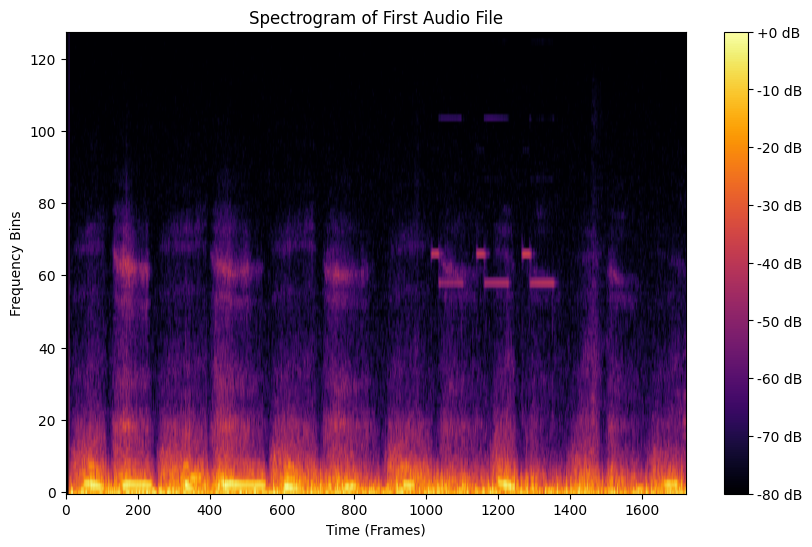

In [5]:

# Check if we have valid data for training
if spectrograms:
    print(f"Spectrograms shape: {np.array(spectrograms).shape}")
else:
    print("No spectrograms to process.")

# Ensure there is data to proceed with
if spectrograms:
    # Visualize a sample spectrogram if available
    plt.figure(figsize=(10, 6))
    plt.imshow(spectrograms[0], aspect='auto', origin='lower', cmap='inferno')
    plt.title('Spectrogram of First Audio File')
    plt.xlabel('Time (Frames)')
    plt.ylabel('Frequency Bins')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

MFCCs shape: (5, 13, 1723)


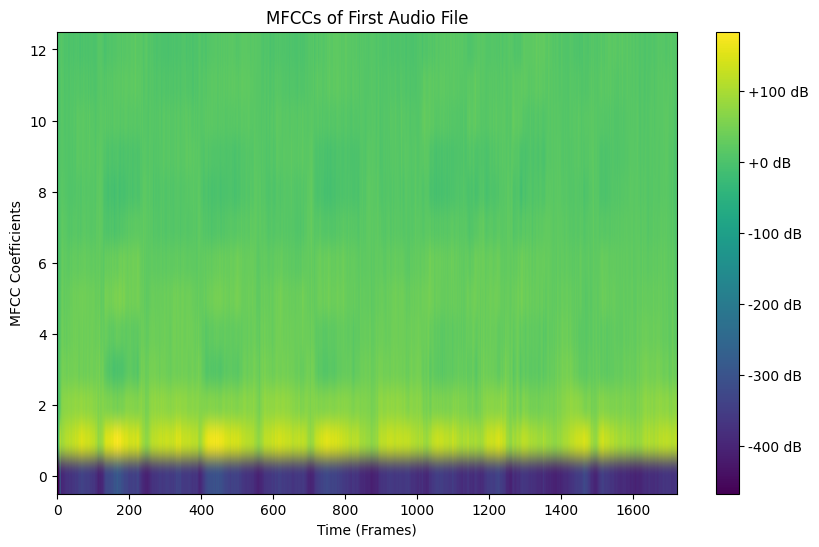

In [6]:
# Check MFCCs
if mfccs:
    print(f"MFCCs shape: {np.array(mfccs).shape}")
else:
    print("No MFCCs to process.")

if mfccs:
    # Visualize MFCCs if available
    plt.figure(figsize=(10, 6))
    plt.imshow(mfccs[0], aspect='auto', origin='lower', cmap='viridis')
    plt.title('MFCCs of First Audio File')
    plt.xlabel('Time (Frames)')
    plt.ylabel('MFCC Coefficients')
    plt.colorbar(format='%+2.0f dB')
    plt.show()


# Model Building

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Function to preprocess data
def preprocess_data(spectrograms, labels):
    if len(spectrograms) == 0:
        raise ValueError("No valid spectrograms to preprocess.")

    spectrograms = np.array(spectrograms)
    max_vals = np.max(spectrograms, axis=(1, 2), keepdims=True)
    spectrograms = spectrograms / (max_vals + 1e-10)

    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)

    # Reshape for CNN input: (samples, height, width, channels)
    spectrograms = spectrograms.reshape(spectrograms.shape[0], spectrograms.shape[1], spectrograms.shape[2], 1)
    return spectrograms, labels

## CNN Model for Spectrograms

In [13]:
def build_cnn_model(input_shape):
    model = models.Sequential([
        tf.keras.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        # Replace flattening with global average pooling to reduce parameter count
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model



In [14]:
# Let's split the data into training and testing sets
labels = ['healthy', 'diseased', 'healthy', 'diseased', 'healthy']
spectrograms, labels = preprocess_data(spectrograms, labels)

# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(spectrograms, labels, test_size=0.2, random_state=42)

<ipython-input-13-807f2285ab9d>:8: RuntimeWarning: overflow encountered in divide
  spectrograms = spectrograms / (max_vals + 1e-10)


In [15]:
# Build the model
input_shape = X_train.shape[1:]
cnn_model = build_cnn_model(input_shape)
cnn_model.summary()

# Train the model
history = cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 126, 1721, 32)       │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 63, 860, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 61, 858, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 30, 429, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 28, 427, 128)        │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 14, 213, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109,313 (427.00 KB)

 Trainable params: 109,313 (427.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.2500 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2500 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2500 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.2500 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2500 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2500 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.2500 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.2500 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.250

In [ ]:
# Optionally, you can visualize the training process
# Plot the accuracy and loss curves
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## XGBoost Model for MFCCs

In [16]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [20]:
def preprocess_data_vgg16(spectrograms, labels, target_size=(224, 224)):
    if len(spectrograms) == 0:
        raise ValueError("No valid spectrograms to preprocess.")

    spectrograms = np.array(spectrograms)
    # Normalize each spectrogram with an epsilon to avoid divide-by-zero issues
    max_vals = np.max(spectrograms, axis=(1, 2), keepdims=True)
    spectrograms = spectrograms / (max_vals + 1e-10)

    # Resize each spectrogram to the target size using TensorFlow
    resized_spectrograms = []
    for img in spectrograms:
        # Ensure image has a channel dimension
        if img.ndim == 2:
            img = np.expand_dims(img, axis=-1)
        img_resized = tf.image.resize(img, target_size).numpy()
        resized_spectrograms.append(img_resized)
    spectrograms = np.array(resized_spectrograms)

    # Convert grayscale images (1 channel) to 3-channel images for VGG16
    if spectrograms.shape[-1] == 1:
        spectrograms = np.repeat(spectrograms, 3, axis=-1)

    # Encode labels as 0 or 1
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)

    return spectrograms, labels

def build_vgg16_model(input_shape):
    base_model = tf.keras.applications.VGG16(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    base_model.trainable = False  # Freeze VGG16 weights

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [21]:
spectrograms, labels = preprocess_data_vgg16(spectrograms, labels, target_size=(224, 224))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(spectrograms, labels, test_size=0.2, random_state=42)

# Build and summarize the model
input_shape = X_train.shape[1:]
vgg_model = build_vgg16_model(input_shape)
vgg_model.summary()

# Train the model
history = vgg_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.2500 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2500 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2500 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.2500 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2500 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2500 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.2500 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2500 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.250

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = vgg_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

In [ ]:
# Optionally, visualize the training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## RandomForest Classification

In [23]:
import os
import glob
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [34]:
def extract_features(file_path, sr=22050, n_mfcc=13):
    """
    Extract audio features including MFCCs, spectral centroid,
    zero crossing rate, spectral bandwidth, and chroma features.
    """
    try:
        y, sr = librosa.load(file_path, sr=sr)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

    if y.size == 0:
        print(f"File {file_path} is empty.")
        return None

    # MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)

    # Spectral centroid
    spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_centroid_mean = np.mean(spec_centroid)
    spec_centroid_std = np.std(spec_centroid)

    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    zcr_mean = np.mean(zcr)
    zcr_std = np.std(zcr)

    # Spectral bandwidth
    spec_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spec_bandwidth_mean = np.mean(spec_bandwidth)
    spec_bandwidth_std = np.std(spec_bandwidth)

    # Chroma features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)
    chroma_std = np.std(chroma, axis=1)

    # Combine features into a dictionary
    features = {}
    for i in range(n_mfcc):
        features[f'mfcc_{i+1}_mean'] = mfcc_mean[i]
        features[f'mfcc_{i+1}_std'] = mfcc_std[i]

    features['spec_centroid_mean'] = spec_centroid_mean
    features['spec_centroid_std'] = spec_centroid_std
    features['zcr_mean'] = zcr_mean
    features['zcr_std'] = zcr_std
    features['spec_bandwidth_mean'] = spec_bandwidth_mean
    features['spec_bandwidth_std'] = spec_bandwidth_std

    for i in range(chroma.shape[0]):
        features[f'chroma_{i+1}_mean'] = chroma_mean[i]
        features[f'chroma_{i+1}_std'] = chroma_std[i]

    return features

In [35]:
audio_files = glob.glob(os.path.join(dataset_path, '**/*.wav'), recursive=True)
print(f"Found {len(audio_files)} audio files.")

feature_list = []
labels = []

# Loop over files and extract features with updated label extraction
for file in audio_files:
    print(f"Processing file: {file}")
    feats = extract_features(file)
    if feats is None:
        print(f"Skipping file due to extraction error: {file}")
        continue
    feature_list.append(feats)

    # Extract label from the file name.
    file_name = os.path.basename(file)
    parts = file_name.split('_')
    if len(parts) >= 3:
        code = parts[2]
        # Map codes to labels. Adjust these mappings as needed.
        if code in ['Ar', 'Lr']:
            label = 'healthy'
        elif code == 'Tc':
            label = 'diseased'
        else:
            label = 'unknown'
    else:
        label = 'unknown'

    labels.append(label)
    # print(f"Extracted label: {label}")

Found 920 audio files.
Processing file: /root/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/151_2p4_Ar_mc_AKGC417L.wav
Extracted label: healthy
Processing file: /root/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/209_1b1_Tc_sc_Meditron.wav
Extracted label: diseased
Processing file: /root/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/147_2b3_Lr_mc_AKGC417L.wav
Extracted label: healthy
Processing file: /root/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/162_1b2_Ar_mc_AKGC417L.wav
Extracted label: healthy
Processing file: /root/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-da

In [36]:
# Create DataFrame from features and labels
df_features = pd.DataFrame(feature_list)
df_features['label'] = labels

# Optionally, filter out rows if you have unwanted labels (adjust if necessary)
# For example, if you only expect 'healthy' and 'diseased' labels:
df_features = df_features[df_features['label'].isin(['healthy', 'diseased'])]

print("Feature DataFrame shape:", df_features.shape)
print(df_features.head())

# Separate features and target labels
X = df_features.drop("label", axis=1)
y = df_features['label']

# Encode string labels to integers (binary classification)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions and evaluate the classifier
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy*100:.2f}%")

Feature DataFrame shape: (410, 57)
   mfcc_1_mean  mfcc_1_std  mfcc_2_mean  mfcc_2_std  mfcc_3_mean  mfcc_3_std  \
0  -343.093536   29.952412   129.464554   23.538984    57.137108   13.150426   
1  -451.000732   49.517796   168.673981   38.312790    33.897675   16.030277   
2  -320.494202   25.450924   119.364792   15.085746    20.680239   17.162554   
3  -331.524872   33.619167   125.750999   32.117439    69.955528   11.766325   
4  -527.357483   22.656822    97.238029   10.683610    27.638781    4.460540   

   mfcc_4_mean  mfcc_4_std  mfcc_5_mean  mfcc_5_std  ...  chroma_8_std  \
0    36.122330   11.134090    42.005981    8.353015  ...      0.289734   
1   -18.121468   22.855856    10.084127   12.731071  ...      0.156312   
2    18.505249   12.401577    29.119179    7.046945  ...      0.196328   
3    30.763178   13.571856    20.663065   10.893734  ...      0.181788   
4    13.274064    7.393581     4.916330    7.320657  ...      0.222528   

   chroma_9_mean  chroma_9_std  chroma_

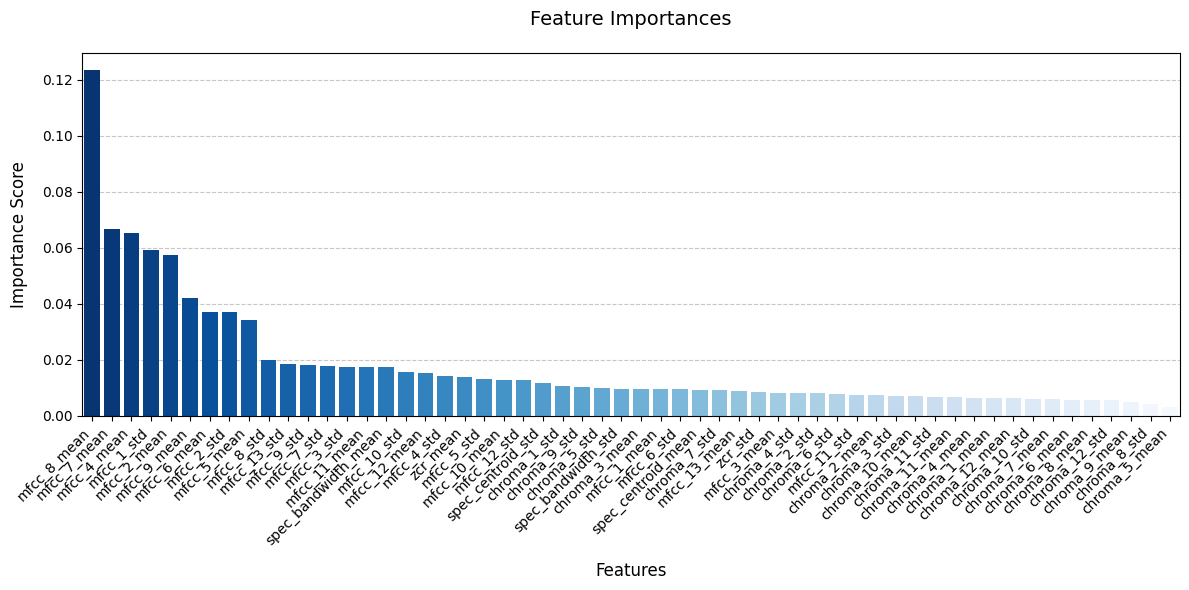

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the style
sns.set_palette("husl")

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Create the bar plot
bars = ax.bar(range(len(importances)),
              importances[indices],
              color=sns.color_palette("Blues_r", len(importances)),
              align="center")

# Customize the plot
ax.set_title("Feature Importances", fontsize=14, pad=20)
ax.set_xlabel("Features", fontsize=12, labelpad=10)
ax.set_ylabel("Importance Score", fontsize=12, labelpad=10)

# Customize x-axis
ax.set_xticks(range(len(importances)))
ax.set_xticklabels(features[indices], rotation=45, ha='right')
ax.set_xlim([-0.5, len(importances)-0.5])

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    # ax.text(bar.get_x() + bar.get_width()/2., height,
    #         f'{height:.3f}',
    #         ha='center', va='bottom')

# Add grid for better readability
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show plot
plt.show()

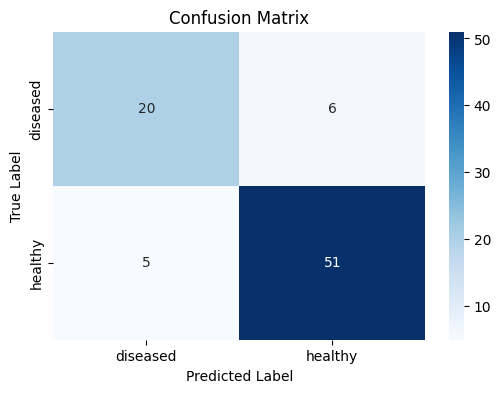

In [40]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()